In [1]:
import numpy as np
import pandas as pd
import networkx as nx

from matplotlib import pyplot as plt
%matplotlib inline

from pyballmapper import BallMapper

# to generate data
from sklearn import datasets

# for finding epsilon net
from tqdm.notebook import tqdm

# for adaptive mapper
from math import log2, log, pi

# Create data and initial ball mapper

In [2]:
X, l = datasets.make_circles(n_samples=200,
                                 shuffle=True,
                                 noise=0.01,
                                 random_state=42,
                                 factor=0.4)

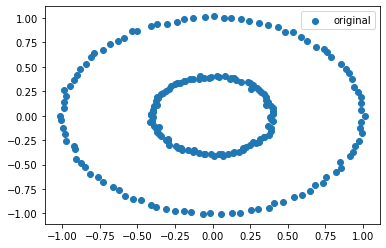

In [3]:
plt.scatter(X[:,0], X[:,1], label = "original")
plt.legend()
plt.show()

In [4]:
bm = BallMapper(points = X, # the pointcloud, as a numpy array
                epsilon = 0.25)            # the radius of the balls

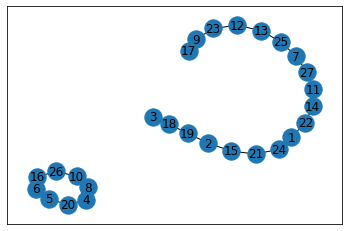

In [5]:
# Ball mapper doesn't work well regardless of epsilon
nx.draw_networkx(bm.Graph, 
                 pos=nx.spring_layout(bm.Graph, seed=24))

# Function to find initial hard clustering

In [145]:
def hard_clustering(points, order, epsilon, distance):
    
    landmarks = []
    
    # get epsilon net
    for idx_p in order:

        # current point
        p = points[idx_p]
        
        is_covered = False

        for idx_v in landmarks:
            if distance(p, points[idx_v]) <= epsilon:
                is_covered = True
                break
                
        if not is_covered:
            landmarks.append(idx_p)
            
    points_covered_by_landmarks = dict()
    for idx_v in landmarks:
        points_covered_by_landmarks[idx_v] = []
        for idx_p in order:
            if distance(points[idx_p], points[idx_v]) <= epsilon:
                points_covered_by_landmarks[idx_v].append(idx_p)
                
    # get hard clustering
    distance_array = np.ones((len(landmarks),len(order)))

    for i,k in enumerate(landmarks):
        for j in points_covered_by_landmarks[k]:
            distance_array[i][order.index(j)] = distance(points[k],points[j])
    
    clustering_indices = np.argmin(distance_array, axis=0)
    
    clustering = [landmarks[i] for i in clustering_indices]
    
    return landmarks, clustering, points_covered_by_landmarks, distance_array

In [125]:
distance_function = lambda x, y : np.linalg.norm(x - y)

In [146]:
test_clustering = hard_clustering(X, range(len(X)), 0.2, distance_function)

In [137]:
testlist = [43,6,8,2]

In [138]:
testlist.index(8)

2

# Function to compute BIC

In [147]:
def bic_centroid(X, c, assignments, BIC=True):
    '''
    Method for computing the BIC or AIC. 
    @param: X - the point cloud to evaluate over. n points x d dimensions
    @param: c - cluster centroids. c centroids x d dimensions
    @params: assigments - Cluster assignments for n points.
    @params: BIC - Defaults to True. Setting False computes the AIC.
    '''
    k = len(c)
    d = X.shape[1]
    R = X.shape[0]
    var = 0
    log_term = 0

    # Sometimes, in sparse cases, a node gets completely split and all members join the neighbors
    empty_clusters = []
    set_assignments = set(assignments)
    for i in range(k):
        if i not in set_assignments:
            empty_clusters.append(i)

    assignments = np.asarray(assignments, dtype=int)
    for i in range(k):
        if i in empty_clusters:
            continue
        cluster_members = X[assignments == i]
        log_term += cluster_members.shape[0] * \
            (log(cluster_members.shape[0]) - log(R))
        sum_squares = np.linalg.norm(cluster_members - c[i], axis=1) ** 2
        var = var + sum_squares.sum()
    k = k - len(empty_clusters)
    var = var / (R - k)
    t2 = -1 * (R*d / 2) * log(2*pi*var)
    t3 = -1 * (1 / 2) * (R-k)
    llh = log_term + t2 + t3
    if BIC:
        return llh - ((k * (d+1))/2) * log(R)  # bic
    else:
        return 2 * llh - ((k * (d + 1))) * 2  # aic

In [148]:
bic_centroid(X, X[test_clustering[0]], test_clustering[1])

-823.2657356801681

# Function to split a ball

In [ ]:
# centers of clusters will always be pre-existing points, so use point labels as cluster labels

In [149]:
test_clustering2 = hard_clustering(X, [11, 14, 15, 67, 83, 126, 140, 141, 142, 150, 151, 163, 193, 198], 0.1, distance_function)